In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import os
import pickle
import random
import seaborn as sns
from tqdm import tqdm
from tqdm import tnrange
from time import time

from sklearn.covariance import MinCovDet
from scipy.stats import chi2


from scipy.stats import multivariate_normal
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, r2_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, linear_model
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1, l2, l1_l2
from sklearn.preprocessing import minmax_scale, OneHotEncoder
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Input, Dense, Reshape, Concatenate, Flatten, Lambda, Reshape, Dropout
from keras.losses import MeanSquaredError as mse
from tensorflow.keras import backend as K
from keras.optimizers import Adam


In [2]:
DATASETS_PATH = "C:/Users/ernest.liu/Documents/git/Morphine-22-23/ML/Datasets/19-01-2023/"
os.chdir(DATASETS_PATH)
os.listdir()

['fall_simulation',
 'fall_simulation2',
 'fall_simulation3',
 'fall_simulation_2.csv',
 'fall_simulation_3.csv',
 'trial_data_1',
 'trial_data_1.csv',
 'trial_data_2',
 'trial_data_2.csv',
 'trial_data_3',
 'trial_data_3.csv',
 'trial_data_4',
 'trial_data_4.csv',
 'trial_data_5',
 'trial_data_5.csv']

In [3]:
adl_files = [file_name for file_name in os.listdir() if ".csv" in file_name and "trial" in file_name]
fall_files = [file_name for file_name in os.listdir() if ".csv" in file_name and "fall" in file_name]

print(adl_files)
print(fall_files)

['trial_data_1.csv', 'trial_data_2.csv', 'trial_data_3.csv', 'trial_data_4.csv', 'trial_data_5.csv']
['fall_simulation_2.csv', 'fall_simulation_3.csv']


In [4]:
trial_data_1 = pd.read_csv(DATASETS_PATH+'trial_data_1.csv').iloc[:,1:]
trial_data_2 = pd.read_csv(DATASETS_PATH+'trial_data_2.csv').iloc[:,1:]
trial_data_3 = pd.read_csv(DATASETS_PATH+'trial_data_3.csv').iloc[:,1:]
trial_data_4 = pd.read_csv(DATASETS_PATH+'trial_data_4.csv').iloc[:,1:]
trial_data_5 = pd.read_csv(DATASETS_PATH+'trial_data_5.csv').iloc[:,1:]

fall_simulation_2 = pd.read_csv(DATASETS_PATH+'fall_simulation_2.csv').iloc[:,1:]
fall_simulation_3 = pd.read_csv(DATASETS_PATH+'fall_simulation_3.csv').iloc[:,1:]

In [5]:
# Only take in accelerometer and gyroscope data
trial_data_1 = trial_data_1[['Ax','Ay','Az','gx','gy','gz']]#.iloc[20:,:]
trial_data_2 = trial_data_2[['Ax','Ay','Az','gx','gy','gz']]#.iloc[20:,:]
trial_data_3 = trial_data_3[['Ax','Ay','Az','gx','gy','gz']]#.iloc[20:,:]
trial_data_4 = trial_data_4[['Ax','Ay','Az','gx','gy','gz']]#.iloc[20:,:]
trial_data_5 = trial_data_5[['Ax','Ay','Az','gx','gy','gz']]#.iloc[20:,:]

fall_simulation_2 = fall_simulation_2[['Ax','Ay','Az','gx','gy','gz']]
fall_simulation_3 = fall_simulation_3[['Ax','Ay','Az','gx','gy','gz']]

In [6]:
train_data = pd.concat([trial_data_1, trial_data_2, trial_data_3, trial_data_4, trial_data_5]).reset_index(drop=True)
test_data = pd.concat([fall_simulation_2, fall_simulation_3]).reset_index(drop=True)

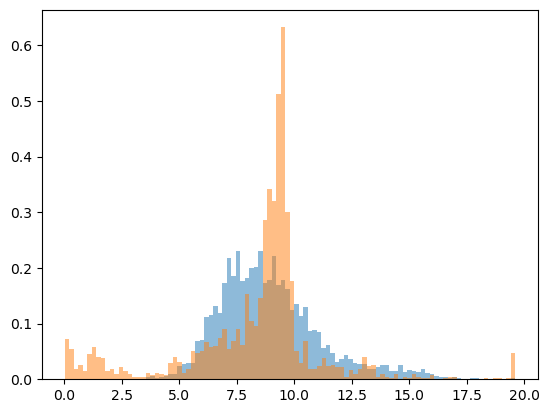

In [7]:
# EDA
plt.hist(np.abs(train_data.Ay), bins=100, alpha=0.5, density=True)
plt.hist(np.abs(test_data.Ay), bins=100, alpha=0.5, density=True)
plt.show()

In [8]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(train_data)

MinMaxScaler()

In [9]:
train_data_norm_presplit = scaler.transform(train_data)
test_data_norm = scaler.transform(test_data)

In [10]:
valid_ratio = 0.2
valid_indices = sorted(random.sample(list(range(train_data_norm_presplit.shape[0])), round(train_data_norm_presplit.shape[0] * valid_ratio)))

In [11]:
valid_data = train_data.iloc[valid_indices, :].reset_index(drop = True)
valid_data_norm = train_data_norm_presplit[valid_indices]
train_data_norm = np.delete(train_data_norm_presplit, valid_indices, axis = 0)

In [12]:
train_data_norm.shape

(106144, 6)

## Mahalanobis Distance Outlier Removal

In [13]:
# Covariance matrix
# covariance = np.cov(train_data, rowvar=False)

start_time = time()
cov = MinCovDet().fit(train_data_norm)
end_time = time()
print(f"Time elapsed: {(end_time - start_time)/60} minutes")
covariance = cov.covariance_

covariance = np.cov(train_data_norm, rowvar=False)

# Covariance matrix power of -1
covariance_pm1 = np.linalg.matrix_power(covariance, -1)

# Center point
centerpoint = np.mean(train_data_norm, axis=0)

Time elapsed: 0.42175363302230834 minutes


In [14]:
# Distances between center point and 
distances = []
for i, val in enumerate(train_data_norm):
    p1 = val
    p2 = centerpoint
    distance = (p1-p2).T.dot(covariance_pm1).dot(p1-p2)
    distances.append(distance)
distances = np.array(distances)

# Cutoff (threshold) value from Chi-Sqaure Distribution for detecting outliers 
cutoff_threshold = 0.99
cutoff = chi2.ppf(cutoff_threshold, train_data_norm.shape[1])

# Index of outliers
outlierIndexes = np.where(distances > cutoff)

print('--- Index of Outliers ----')
print(outlierIndexes)
print(f"There are {len(outlierIndexes[0])} outliers identified")

print('--- Observations found as outlier -----')
print(train_data_norm[distances > cutoff, :])



--- Index of Outliers ----
(array([  4405,   4406,   4407, ..., 105980, 105981, 105982], dtype=int64),)
There are 4849 outliers identified
--- Observations found as outlier -----
[[0.4500255  0.48085901 0.31693014 1.         0.         0.40160183]
 [0.44849567 0.47338936 0.33426823 1.         0.         0.39816934]
 [0.44263131 0.47432306 0.30953595 1.         0.         0.39702517]
 ...
 [0.60963794 0.71848739 0.26160122 0.75514874 1.         0.35011442]
 [0.59433962 0.77404295 0.23916369 0.70480549 1.         0.34897025]
 [0.57623661 0.82913165 0.22131566 0.63844394 1.         0.35011442]]


In [ ]:
train_data_norm = np.delete(train_data_norm, outlierIndexes, axis = 0)

## Building Model

In [ ]:
latent_space_dim = 2
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(latent_space_dim,), mean=0., stddev=1.) # stddev is set to 0.1 in this post: https://blog.keras.io/building-autoencoders-in-keras.html
    return_value = z_mean + K.exp(z_log_sigma) * epsilon
    #print(z_mean)
    
    return return_value

### Encoder

In [ ]:
inputs = Input((6,))
layer1 = Dense(6, activation = 'relu')(inputs)
layer2 = Dense(200, activation = 'relu')(layer1) # Changed from 3
layer3 = Dense(100, activation = 'relu')(layer2) # Changed from 3
layer4 = Dense(60, activation = 'relu')(layer3)
layer5 = Dense(30, activation = 'relu')(layer4)
z_mean = Dense(latent_space_dim)(layer5)
z_log_sigma = Dense(latent_space_dim)(layer5)
encoder = keras.Model(inputs, [z_mean, z_log_sigma], name="encoder")
encoder.summary()

### Sampler

In [ ]:
sampler_input1 = keras.Input(shape=(latent_space_dim,))
sampler_input2 = keras.Input(shape=(latent_space_dim,))
latent_sample = Lambda(sampling, output_shape = (latent_space_dim,))([sampler_input1, sampler_input2])
sampler = keras.Model([sampler_input1, sampler_input2], latent_sample)

### Decoder

In [ ]:
latent_inputs = keras.Input(shape=(latent_space_dim,))
layer6 = Dense(20, activation = 'relu')(latent_inputs)
layer7 = Dense(30, activation = 'relu')(layer6)
layer8 = Dense(50, activation = 'relu')(layer7)
layer9 = Dense(100, activation = 'relu')(layer8)
layer10 = Dense(200, activation = 'relu')(layer9)
decoder_outputs = Dense(6, activation = 'sigmoid')(layer10)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

## VAE

In [ ]:
class VAE(Model):
    def __init__(self, encoder, sampler, decoder, beta = 1, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.sampler = sampler
        self.decoder = decoder
        self.beta = beta
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_sigma = self.encoder(data)
            z_log_var = 2 * z_log_sigma
            z = self.sampler([z_mean, z_log_var])
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(keras.losses.binary_crossentropy(data, reconstruction))
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(kl_loss)
            total_loss = reconstruction_loss + self.beta * kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    def test_step(self, data):
        if isinstance(data, tuple):
            #print(f"Ran. data: {data}")
            data = data[0]

        z_mean, z_log_sigma = self.encoder(data)
        z_log_var = 2 * z_log_sigma
        z = self.sampler([z_mean, z_log_var])
        reconstruction = self.decoder(z)
        reconstruction_loss = tf.reduce_mean(keras.losses.binary_crossentropy(data, reconstruction))
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(kl_loss)
        total_loss = reconstruction_loss + self.beta * kl_loss
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }
    
    
    def call(self, data):
        z_mean, z_log_sigma = self.encoder(data)
        z_log_var = 2 * z_log_sigma
        z = self.sampler([z_mean, z_log_var])
        reconstruction = self.decoder(z)
        reconstruction_loss = tf.reduce_mean(keras.losses.binary_crossentropy(data, reconstruction))
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(kl_loss)
        total_loss = reconstruction_loss + self.beta * kl_loss
        self.add_metric(kl_loss, name='kl_loss', aggregation='mean')
        self.add_metric(total_loss, name='total_loss', aggregation='mean')
        self.add_metric(reconstruction_loss, name='reconstruction_loss', aggregation='mean')
        return reconstruction
    

In [ ]:
vae = VAE(encoder, sampler, decoder, beta = 0.01)
vae.compile(optimizer = 'adam')

In [ ]:
callback = EarlyStopping(
    monitor="val_loss",
    patience=5
)

history = vae.fit(x = train_data_norm, y = train_data_norm, # Changed from train_data_norm 
                  epochs = 1000,
                  shuffle = True,
                  batch_size = 32,
                  workers = 8,
                  validation_data = (valid_data_norm, valid_data_norm), # Changed from valid_data_norm
                  callbacks = [callback])

In [ ]:
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.legend()
plt.show()

In [ ]:
train_predictions = vae.predict(train_data_norm)
test_predictions = vae.predict(test_data_norm)
valid_predictions = vae.predict(valid_data_norm)

In [ ]:
model_name = "vae_fixed_loss_beta_0_01"
# os.chdir("C:/Users/ernest.liu/Documents/git/Morphine-22-23/ML/Model/weights/")
# vae.save_weights(model_name)

In [ ]:
print(f"Training MAE: {np.sum(np.abs(train_data_norm - train_predictions))/(train_data_norm.shape[0] * train_data_norm.shape[1])}")
print(f"Testing MAE (Anomalous Data): {np.sum(np.abs(test_data_norm - test_predictions))/(test_data_norm.shape[0] * test_data_norm.shape[1])}")
print(f"Validation MAE (Normal Data): {np.sum(np.abs(valid_data_norm - valid_predictions))/(valid_data_norm.shape[0] * valid_data_norm.shape[1])}")

In [ ]:
train_mae = np.sum(np.abs(train_data_norm - train_predictions), axis = 1)
plt.hist(train_mae, bins = 20)
plt.title("Training Dataset")
plt.xlabel("Reconstruction Error (MAE)")
plt.ylabel("Count")
plt.show()

In [ ]:
valid_mae = np.sum(np.abs(valid_data_norm - valid_predictions), axis = 1)
plt.hist(valid_mae, bins = 20)
plt.title("Validation (Normal Samples) Dataset")
plt.xlabel("Reconstruction Error (MAE)")
plt.ylabel("Count")
plt.show()

In [ ]:
test_mae = np.sum(np.abs(test_data_norm - test_predictions), axis = 1)
plt.hist(test_mae, bins = 20)
plt.title("Testing (Anomalous) Dataset")
plt.xlabel("Reconstruction Error (MAE)")
plt.ylabel("Count")
plt.show()

In [ ]:
best_threshold = np.quantile(valid_mae, 0.9)

In [ ]:
best_threshold

In [ ]:
train_data["mae"] = np.sum(np.abs(scaler.transform(train_data) - vae.predict(scaler.transform(train_data))), axis = 1)
train_data["is_anomalous"] = train_data.mae > best_threshold

test_data["mae"] = test_mae
test_data["is_anomalous"] = test_mae > best_threshold

In [ ]:
test_data

In [ ]:
plt.scatter(test_data.index, test_data.mae, s = 0.2)
plt.axhline(y=best_threshold, color='r', linestyle='-')
plt.show()

In [ ]:
plt.scatter(train_data.index, train_data.mae, s = 0.2)
plt.axhline(y=best_threshold, color='r', linestyle='-')
plt.show()

In [ ]:
np.sum(test_data.is_anomalous)/test_data.shape[0]

In [ ]:
np.sum(train_data.is_anomalous)/train_data.shape[0]

## Loading Model

In [ ]:
latent_space_dim = 2
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(latent_space_dim,), mean=0., stddev=1.) # stddev is set to 0.1 in this post: https://blog.keras.io/building-autoencoders-in-keras.html
    return_value = z_mean + K.exp(z_log_sigma) * epsilon
    #print(z_mean)
    
    return return_value

In [ ]:
inputs = Input((6,))
layer1 = Dense(6, activation = 'relu')(inputs)
layer2 = Dense(200, activation = 'relu')(layer1) # Changed from 3
layer3 = Dense(100, activation = 'relu')(layer2) # Changed from 3
layer4 = Dense(60, activation = 'relu')(layer3)
layer5 = Dense(30, activation = 'relu')(layer4)
z_mean = Dense(latent_space_dim)(layer5)
z_log_sigma = Dense(latent_space_dim)(layer5)
encoder = keras.Model(inputs, [z_mean, z_log_sigma], name="encoder")
encoder.summary()

In [ ]:
sampler_input1 = keras.Input(shape=(latent_space_dim,))
sampler_input2 = keras.Input(shape=(latent_space_dim,))
latent_sample = Lambda(sampling, output_shape = (latent_space_dim,))([sampler_input1, sampler_input2])
sampler = keras.Model([sampler_input1, sampler_input2], latent_sample)

In [ ]:
latent_inputs = keras.Input(shape=(latent_space_dim,))
layer6 = Dense(20, activation = 'relu')(latent_inputs)
layer7 = Dense(30, activation = 'relu')(layer6)
layer8 = Dense(50, activation = 'relu')(layer7)
layer9 = Dense(100, activation = 'relu')(layer8)
layer10 = Dense(200, activation = 'relu')(layer9)
decoder_outputs = Dense(6, activation = 'sigmoid')(layer10)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

In [ ]:
class VAE(Model):
    def __init__(self, encoder, sampler, decoder, beta = 1, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.sampler = sampler
        self.decoder = decoder
        self.beta = beta
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_sigma = self.encoder(data)
            z_log_var = 2 * z_log_sigma
            z = self.sampler([z_mean, z_log_var])
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(keras.losses.binary_crossentropy(data, reconstruction))
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(kl_loss)
            total_loss = reconstruction_loss + self.beta * kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    def test_step(self, data):
        if isinstance(data, tuple):
            #print(f"Ran. data: {data}")
            data = data[0]

        z_mean, z_log_sigma = self.encoder(data)
        z_log_var = 2 * z_log_sigma
        z = self.sampler([z_mean, z_log_var])
        reconstruction = self.decoder(z)
        reconstruction_loss = tf.reduce_mean(keras.losses.binary_crossentropy(data, reconstruction))
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(kl_loss)
        total_loss = reconstruction_loss + self.beta * kl_loss
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }
    
    
    def call(self, data):
        z_mean, z_log_sigma = self.encoder(data)
        z_log_var = 2 * z_log_sigma
        z = self.sampler([z_mean, z_log_var])
        reconstruction = self.decoder(z)
        reconstruction_loss = tf.reduce_mean(keras.losses.binary_crossentropy(data, reconstruction))
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(kl_loss)
        total_loss = reconstruction_loss + self.beta * kl_loss
        self.add_metric(kl_loss, name='kl_loss', aggregation='mean')
        self.add_metric(total_loss, name='total_loss', aggregation='mean')
        self.add_metric(reconstruction_loss, name='reconstruction_loss', aggregation='mean')
        return reconstruction
    

In [ ]:
vae = VAE(encoder, sampler, decoder, beta = 0.01)
vae.compile(optimizer = 'adam')

In [ ]:
os.chdir("C:/Users/ernest.liu/Documents/git/Morphine-22-23/ML/Model/weights/")
model_name = "vae_fixed_loss_beta_0_01"
vae.load_weights(model_name)

In [ ]:
train_predictions = vae.predict(train_data_norm)
test_predictions = vae.predict(test_data_norm)
valid_predictions = vae.predict(valid_data_norm)

In [ ]:
valid_mae = np.sum(np.abs(valid_data_norm - valid_predictions), axis = 1)
best_threshold = np.quantile(valid_mae, 0.9)

In [ ]:
best_threshold

In [ ]:
scaler.transform(train_data)

In [ ]:
pickle.dump(scaler, open('scaler.pkl', 'wb'))

In [ ]:
pwd

In [ ]:
os.chdir("C:/Users/ernest.liu/Documents/git/Morphine-22-23/ML/Docker/")

In [ ]:
import firebase_admin
from firebase_admin import db
from datetime import datetime
import time
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Connection to Firebase
cred_obj = firebase_admin.credentials.Certificate("../Morphine2.json")
default_app = firebase_admin.initialize_app(cred_obj, {
  'databaseURL':'https://morphine-64cdd-default-rtdb.asia-southeast1.firebasedatabase.app/'
  })
USERS_DATA = db.reference("/Users Data/Token UID:XvIeVwC7M0QN0qW15FNYO2e5BJ93")
FIREBASE_PREDICTION_PATH = db.reference("/Users Data/Token UID:XvIeVwC7M0QN0qW15FNYO2e5BJ93/Split Circuit/MPU6050/MPU6050 Fall/")

# Process GPS Data
GPS_KEYWORDS_LIST = ['Latitude: ', '(*10^-7) Longitude: ', '(*10^-7) Altitude: ', '(mm) Satellite-in-view: ', 'timing for this set: ']
GPS_KEYWORDS_LENGTH = [len(keyword) for keyword in GPS_KEYWORDS_LIST]

def process_gps_datapoints(gps_datapoints):
    """
    gps_datapoints = gps_data['GPS Datapoints']
    """
    gps_datapoints = gps_datapoints[0]
    indices = [gps_datapoints.find(keyword) for keyword in GPS_KEYWORDS_LIST]
    # Latitude, Longtiude, Altitude, Satellite-in-view, timing for this set
    gps_datapoints_list = []
    for i, index in enumerate(indices):
        if i == len(indices) - 1:
            gps_datapoints_list.append(float(gps_datapoints[index + GPS_KEYWORDS_LENGTH[i]:].strip()))
        else:
            gps_datapoints_list.append(float(gps_datapoints[index + GPS_KEYWORDS_LENGTH[i]:indices[i+1]].strip()))
    return gps_datapoints_list

def process_gps(gps):
    """
    gps = data['Split Circuit']['GPS']
    """
    processed_gps_data = []
    gps_accounter = gps['GPS Accounter']
    gps_datapoints = gps['GPS Datapoints']
    gps_loopSpeedArr = gps['GPS LoopSpeedArr'][0]
    gps_uploadSpeedArr = gps['GPS UploadSpeedArr'][0]
    
    processed_gps_datapoints = process_gps_datapoints(gps_datapoints)
    
    processed_gps_data.append(gps_accounter)
    processed_gps_data.extend(processed_gps_datapoints)
    processed_gps_data.extend([gps_loopSpeedArr, gps_uploadSpeedArr])
    
    new_gps_df = pd.DataFrame([processed_gps_data],
                             columns = ['accounter', 'latitude', 'longitude', 'altitude', 'satelliteInView', 'timingForThisSet', 'LoopSpeed', 'UploadSpeed'])
    return new_gps_df

# process MPU6050
MPU6050_KEYWORDS = ['Ax: ', 'Ay: ', 'Az: ', 'gx: ', 'gy: ', 'gz: ', 'temp: ', 'timing for this set: ']
MPU6050_KEYWORDS_LENGTH = [len(x) for x in MPU6050_KEYWORDS]

## function to process one datapoint
def process_one_set_of_datapoint(output_set):
    indexes = [output_set.find(keyword) for keyword in MPU6050_KEYWORDS]
    df_row = []
    curr_data_index = int(output_set[:indexes[0]].strip())
    df_row.append(curr_data_index) # append in the index of the new input
    for i, index in enumerate(indexes):
        if i == len(indexes) - 1:
            x = float(output_set[index+MPU6050_KEYWORDS_LENGTH[i]:].strip())
            df_row.append(x)
        else:
            x = float(output_set[index+MPU6050_KEYWORDS_LENGTH[i]: indexes[i+1]].strip())
            df_row.append(x)
    return df_row

def process_mpu6050(mpu6050, timeDifference):
    """
    mpu6050_output = split_circuit_data['MPU6050']
    """
    mpu6050_df = pd.DataFrame(columns = ['accounter', 'LoopSpeedArr', 'UploadSpeedArr', 'set_index', 'Ax', 'Ay', 'Az', 'gx', 'gy', 'gz', 'temp', 'timingForThisSet', 'timeDifference'])
    accounter = mpu6050['MPU6050 Accounter']
    mpu6050_datapoints = mpu6050['MPU6050 Datapoints'][0]
    mpu6050_loopSpeedArr = mpu6050['MPU6050 LoopSpeedArr'][0]
    mpu6050_uploadSpeedArr = mpu6050['MPU6050 UploadSpeedArr'][0]
    mpu6050_output_sets = mpu6050_datapoints.split('Set: ')[1:]
    
    for output in mpu6050_output_sets:
        data = [accounter, mpu6050_loopSpeedArr,mpu6050_uploadSpeedArr]
        datapoint = process_one_set_of_datapoint(output)
        data.extend(datapoint)
        data.append(timeDifference)
        new_df = pd.DataFrame([data], 
                              columns = ['accounter', 'LoopSpeedArr', 'UploadSpeedArr', 'set_index', 'Ax', 'Ay', 'Az', 'gx', 'gy', 'gz', 'temp', 'timingForThisSet', 'timeDifference'])
        mpu6050_df = pd.concat([mpu6050_df, new_df], ignore_index = True)
    return mpu6050_df

# overall function to read split circuit
def process_split_ciruit_data(split_circuit_data):
    """
    split_circuit_data = data['Split Circuit']
    """
    gps_df = pd.DataFrame(columns = ['accounter', 'latitude', 'longitude', 'altitude', 'satelliteInView', 'timingForThisSet', 'LoopSpeed', 'UploadSpeed'])
    mpu6050_df = pd.DataFrame(columns = ['accounter', 'LoopSpeedArr', 'UploadSpeedArr', 'set_index', 'Ax', 'Ay', 'Az', 'gx', 'gy', 'gz', 'temp', 'timingForThisSet', 'timeDifference'])

    keys = split_circuit_data.keys()
    for key in keys:
        if key == 'GPS':
            gps_data = split_circuit_data['GPS']
            processed_gps_data = process_gps(gps_data)
            gps_df = pd.concat([gps_df, processed_gps_data])
            print('Extracted GPS Data')
            
        elif key == 'GPS Button':
            print("GPS Button:", split_circuit_data['GPS Button'])
            
        elif key == 'MPU6050':
            mpu6050_output = split_circuit_data['MPU6050']
            processed_mpu6050_output = process_mpu6050(mpu6050_output, None)
            mpu6050_df = pd.concat([mpu6050_df, processed_mpu6050_output])
            print('Extracted MPU6050 Data')
    return gps_df, mpu6050_df

# MAIN FUNCTION to read data from Google Firebase
def read_data():
    data = USERS_DATA.get()
    split_circuit_data = data['Split Circuit']
    gps_df, mpu6050_df = process_split_ciruit_data(split_circuit_data)
    return gps_df, mpu6050_df

def predict(wave_data, t1=8.6396, t2=0.5):
    """
    Actual:
    This function make use of the autoencoder model to predict one wave of data - 20 datapoints.
    The model will predict whether each of this 20 datapoints is ADL or Fall from the reconstruction error threshold, t1.
    If the number of datapoints in a wave is more than a certain threshold, t2, we will then classify it as Fall, else ADL.

    For now:
    t1 is threshold to classify one datapoint based on the y-axis of accelerometer 
    t2 is threshold to classify a wave - 0.5 i.e. if >= 50% of the datapoints are anomalous, this wave will be classified as fall
    """
    return np.sum(np.abs(wave_data.Ay) > t1) >= t2 * wave_data.shape[0]

def write_to_firebase(prediction, prediction_path=FIREBASE_PREDICTION_PATH):
    """ Write results to firebase """
    if prediction.lower() == "fall detected":
        prediction_path.update({"0":"Fall Detected"})
    elif prediction.lower() == "normal":
        prediction_path.update({"0":"Normal"})

# if __name__ == "__main__":
#     while True:
#         gps_df, mpu6050_df = read_data()
#         print("GPS and MPU6050 Dataframe Shape:", gps_df.shape, mpu6050_df.shape)
#         # prediction = predict(wave_data=mpu6050_df.values)
#         prediction = "Fall detected"
#         print("Prediction:", prediction.title())
#         # write_to_firebase(prediction)
#         print("Updated Firebase!")
#         print()


In [ ]:
gps_df, mpu6050_df = read_data()
test_data = read_data()[1][["Ax", "Ay", "Az", "gx", "gy", "gz"]]

In [ ]:
scaler.transform(test_data)

In [ ]:
test_data